## Units heatmaps

Plot a few heatmaps for some M2 units

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from fcutils.progress import track

import sys
sys.path.append("./")
sys.path.append(r"C:\Users\Federico\Documents\GitHub\pysical_locomotion")

from analysis.ephys.utils import get_recording_names, get_data

glm_cache = Path(
    r"D:\GLM\data"
)



In [ ]:
TARGET = "MOs"
# recordings = get_recording_names(region=TARGET)

rec = "FC_220433_BAA1101192_hairpin"  # 33, 34, 35

_data = pd.read_hdf(glm_cache / f"{rec}_bouts.h5")
_tracking = pd.read_hdf(glm_cache / f"{rec}_bouts_xy.h5")

In [ ]:
variables = ("v", "v_squared", "dv_300ms", "omega", "domega_300ms", "omega_squared", "apex_distance")
units = [c for c in _data.columns if c not in variables and "shuffle" not in c]

mins_speed = 0

data_reverse = _data.loc[(_tracking.ds > -300)&(_tracking.ds < 0)&(_data.v > mins_speed)][units]
data = _data.loc[(_tracking.ds > 0)&(_tracking.ds < 300)&(_data.v > mins_speed)][units]
tracking_reverse = _tracking.loc[(_tracking.ds > -300)&(_tracking.ds < 0)&(_data.v > mins_speed)]
tracking = _tracking.loc[(_tracking.ds > 0)&(_tracking.ds < 300)&(_data.v > mins_speed)]

In [ ]:
# sort units by the average firing rate
firing_rates = data.max()
firing_rates = firing_rates.sort_values(ascending=False)
firing_rates

mean_firing_rates = data.mean()
mean_firing_rates = mean_firing_rates.sort_values(ascending=False)

In [ ]:
# plot hexbin of XY coordinates and a unit's firing rate
from fcutils.plot.figure import calc_nrows_ncols

nrows, ncols = calc_nrows_ncols(len(units), aspect=(1, 1))

f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 25))
axes = axes.flatten()[:len(units)]

for unit_id, ax in enumerate(axes):
    unit = firing_rates.index[unit_id]
    unit_fr = data[unit]
    # clip firing rate to 99th percentile
    unit_fr = unit_fr.clip(upper=np.percentile(unit_fr, 95))
    unit_fr_reversed = data_reverse[unit]

    ax.axis("equal")
    ax.set(title= f"Unit {unit_id}: {unit}")
    ax.axis("off")
    ax.hexbin(tracking.x, tracking.y, unit_fr, gridsize=[16, 24],   cmap="bwr", mincnt=10, vmin=np.percentile(unit_fr, 5), vmax=np.percentile(unit_fr, 96))
    ax.hexbin(tracking_reverse.x + 41, tracking_reverse.y, unit_fr_reversed, gridsize=[16, 24],   cmap="bwr", mincnt=10, vmin=np.percentile(unit_fr, 5), vmax=np.percentile(unit_fr, 96))

## Plot selected units
with more details

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="15%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    cbar.set_label(cbar_label)
    return cbar


In [ ]:
selected_units = [
    # (7, 4, 12),
    # (9, 8, 28),
    # (18, 5, 13),
    # (24, 0, 10),
    # (25, 2, 15),
    # (32, 0, 12),
    (34, 0, 6),
]

for unit_id, min_fr, max_fr in selected_units:
    unit_num = firing_rates.index[unit_id]
    unit_fr = data[unit_num].values
    unit_fr_reversed = data_reverse[unit_num].values

    
    # unit_fr = unit_fr.clip(upper=np.percentile(unit_fr, 95))
    f, ax = plt.subplots(figsize=(8, 12))
    ax.axis("equal")
    ax.set(title= f"Unit {unit_id}: {unit}")
    ax.axis("off")
    im = ax.hexbin(tracking.x.values, tracking.y.values, unit_fr, gridsize=[24, 36],   cmap="magma", mincnt=10, vmin=min_fr, vmax=max_fr)
    ax.hexbin(tracking_reverse.x.values + 45, tracking_reverse.y.values, unit_fr_reversed, gridsize=[24, 36],   cmap="magma", mincnt=10, vmin=min_fr, vmax=max_fr)
    add_colorbar(ax, im, "Firing rate (Hz)")

    
    # save figure
    f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\activity_heatmaps_{rec}_unit_{unit_num}.svg", dpi=300)
    break

## Behavior heatmaps

In [ ]:
# Plot tracking data from all behavioral data

alldata_tracking = {}
all_data = {}
for REC in track(get_recording_names(region=TARGET)):
    # fetch recording data
    all_data[REC] = pd.read_hdf(glm_cache / f"{REC}_bouts.h5")
    alldata_tracking[REC] =  pd.read_hdf(glm_cache/f"{REC}_bouts_xy.h5")

In [ ]:
data = pd.concat([df[["v", "omega"]] for df in all_data.values()], ignore_index=True)
tracking = pd.concat(alldata_tracking.values(), ignore_index=True)
del all_data
del alldata_tracking


<AxesSubplot:>

<Figure size 432x288 with 1 Axes>

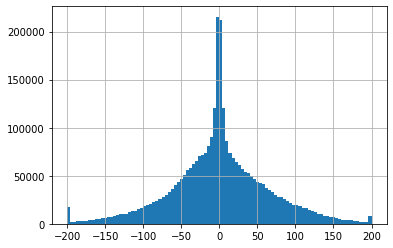

In [91]:
from fcutils.maths import derivative 

tracking["v"] = data["v"]
tracking["omega"] = data["omega"]
tracking["dv"] = np.clip(derivative(tracking["v"].values * 1000), -200, 200)
tracking["domega"] = np.clip(derivative(tracking["omega"].values * 1000), -2000, 2000)

tracking["dv"].hist(bins=100)

In [99]:
def add_colorbar(ax, im, cbar_label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
    cbar.set_label(cbar_label)
    return cbar

def heatmap(ax, X, Y, Z, cmap, label, vmin=None, vmax=None):
    im = ax.hexbin(
        X, Y, Z, cmap=cmap, vmin=vmin, vmax=vmax, gridsize=(40, 60), mincnt=50
    )
    add_colorbar(ax, im, label)
    ax.axis("equal")
    ax.axis("off")

In [93]:
tracking.head()

,x,y,s,ds,v,omega,dv,domega
0,11.092033,6.431960,39.750149,39912.031250,10.135716,81.643074,200.000000,2000.000000
1,11.089713,6.437934,39.755199,4.638844,10.205870,81.326241,70.153320,-316.828125
2,11.086042,6.442625,39.760254,4.651090,10.279806,81.068001,73.935547,-258.242188
3,11.082371,6.447316,39.765305,4.662655,10.353744,80.809761,73.937500,-258.242188
4,11.078699,6.452007,39.770355,4.673590,10.427680,80.551529,73.936523,-258.226562


<Figure size 1440x360 with 8 Axes>

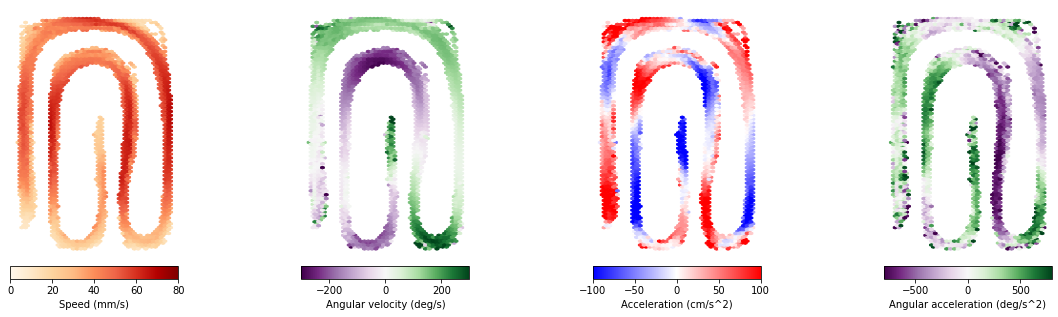

In [100]:
f, axes = plt.subplots(1, 4, figsize=(20, 5))

x = tracking.loc[(tracking.v > 10) & (tracking.ds < 0)].x.values
y = tracking.loc[(tracking.v > 10) & (tracking.ds < 0)].y.values
v = tracking.loc[(tracking.v > 10) & (tracking.ds < 0)].v.values
omega = tracking.loc[(tracking.v > 10) & (tracking.ds < 0)].omega.values
dv = tracking.loc[(tracking.v > 10) & (tracking.ds < 0)].dv.values
domega = tracking.loc[(tracking.v > 10) & (tracking.ds < 0)].domega.values



heatmap(axes[0], x, y, v, "OrRd", "Speed (mm/s)", vmin=0, vmax=80)
heatmap(axes[1], x, y, omega, "PRGn", "Angular velocity (deg/s)", vmin=-300, vmax=300)
heatmap(axes[2], x, y, dv, "bwr", "Acceleration (cm/s^2)", vmin=-100, vmax=100)
heatmap(axes[3], x, y, domega, "PRGn", "Angular acceleration (deg/s^2)", vmin=-800, vmax=800)

f.savefig(f"D:\\Dropbox (UCL)\\Rotation_vte\\Writings\\THESIS\\Chpt4\\Plots\\activity_heatmaps_tacking_data_inward.svg", dpi=300)

## Plot tuning curves

In [ ]:
# _bins = pd.cut(_data.v, bins=np.arange(0, 100, 5))
# groups = _data.groupby(_bins)
# mu = groups.mean()
# sigma = groups.std()
# counts = groups.count().v

# mu = mu.dropna()
# sigma = sigma.dropna()
# mu = mu.loc[counts > 5000]
# sigma = sigma.loc[counts > 5000]

# bin_values = [b.mid if isinstance(b, pd.Interval) else np.nan for b in mu.index]

In [ ]:
from fcutils.plot.elements import plot_mean_and_error

idx = 47
f, ax = plt.subplots(figsize=(16, 9))
ax.set(title=units[idx])
plot_mean_and_error(
    mu[units[idx]], sigma[units[idx]], ax=ax, color="red", x=bin_values
)
# plt.plot(bin_values, mu[units[idx]].values, lw=2, color="red")

for i in range(100):
    # plt.plot(
    #     bin_values, mu[units[idx]+f"_shuffle_{i}"].values, lw=0.5, color="k", zorder=-1, alpha=0.1
    # )
    
    plot_mean_and_error(
        mu[units[idx]+f"_shuffle_{i}"], sigma[units[idx]+f"_shuffle_{i}"], ax=ax, err_alpha=.01, alpha=.2, lw=1, color="k", zorder=-1, x=bin_values
    )